# results visualization

In [36]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


with open('output_MRP/test_tables_train8_test2.pkl', 'rb') as file:
    test_list = pickle.load(file)

with open('output_MRP/train_tables_train8_test2.pkl', 'rb') as file:
    train_list = pickle.load(file)



## Part I: statistics report

In [34]:
def trade_table_statistics(table):

    # calculate the daily return
    table['ret'] = table['cum_ret'] / table['cum_ret'].shift(1) - 1

    # 1. calcualte number of openings/closings achieved during the period
    prev_pos = table['position'].shift(1)
    prev_pos.iloc[0] = 0
    mask = (table['position'] == 0)
    num_closings = np.sum(np.abs(prev_pos[mask]))

    mask = (prev_pos == 0)
    num_openings = np.sum(np.abs(table['position'][mask]))


    # 2. cum return over the period
    final_cum_ret = table['cum_ret'].iloc[-1]

    # 3. start_date and end_date
    start_date = table.index[0]
    end_date = table.index[-1]

    # 4. max_drawdown
    cum_ret = table['cum_ret']

    def calculate_max_drawdown(value_series):
        curr_max = value_series.iloc[0]
        max_drawdown = 0

        for val in value_series:
            if val > curr_max:
                curr_max = val

            drawdown = val / curr_max - 1
            if drawdown < max_drawdown:
                max_drawdown = drawdown


        return max_drawdown

    max_drawdown = calculate_max_drawdown(cum_ret)

    # 5. nav percentile
    cum_ret = table['cum_ret']
    nav_min = np.min(cum_ret)
    nav_max = np.max(cum_ret)
    nav_median = np.median(cum_ret)
    nav_25 = np.percentile(cum_ret, 25)
    nav_75 = np.percentile(cum_ret, 75)

    # 6. sharpe ratio (daily basis)
    daily_ret = table['ret'].iloc[1:] # first ret is NaN
    sharpe_daily = np.mean(daily_ret) / np.std(daily_ret)

    # 7. geometric averate daily ret
    cum_ret = table['cum_ret'].iloc[-1]
    num_periods = len(table) - 1
    average_daily_ret = cum_ret ** (1/num_periods) - 1 

    # 8. average holding period
    def calculate_holding_periods(position_series):
        total_holding_days = 0
        total_num_opens = 0
        curr_open = False

        for position in position_series:
            if not curr_open:
                if position != 0:
                    curr_open = True
                    total_num_opens += 1
            else:
                total_holding_days += 1
                if position == 0:
                    curr_open = False
        average_holding_period = total_holding_days / total_num_opens

        return average_holding_period
    position_series = table['position']
    average_holding_period = calculate_holding_periods(position_series)

    stats = {
        'start_date': start_date,
        'end_date': end_date,

        'sharpe_daily': sharpe_daily,
        'cum_return': final_cum_ret,
        'max_drawdown': max_drawdown,
        'average_daily_ret': average_daily_ret,

        'nav_min': nav_min,
        'nav_25': nav_25,
        'nav_median': nav_median,
        'nav_75': nav_75,
        'nav_max': nav_max,

        'num_openings': num_openings,
        'num_closings': num_closings,
        'average_holding_period': average_holding_period,
    }
    
    return stats


def create_stats_summary(table_list):
    summary_df = pd.DataFrame()
    
    for table in table_list:

        stats = trade_table_statistics(table)
        stats_df = pd.DataFrame([stats])
        summary_df = pd.concat([summary_df, stats_df], ignore_index=True)
    
    return summary_df

stats_df = create_stats_summary(test_list)
stats_df.head()


,start_date,end_date,sharpe_daily,cum_return,max_drawdown,average_daily_ret,nav_min,nav_25,nav_median,nav_75,nav_max,num_openings,num_closings,average_holding_period
0,1990-08-29,1990-10-26,-0.018194,0.973326,-0.081294,-0.000659,0.929188,0.963751,0.978158,0.990829,1.011409,1.0,0.0,41.000000
1,1990-10-26,1990-12-26,-0.033102,0.902667,-0.152326,-0.002494,0.875625,0.928621,0.953027,0.986130,1.032974,1.0,0.0,40.000000
2,1990-12-26,1991-02-25,0.030981,0.997367,-0.320248,-0.000064,0.933459,1.001481,1.102706,1.260440,1.373234,4.0,3.0,8.250000
3,1991-02-25,1991-04-24,0.388756,1.604982,-0.047920,0.011606,1.000000,1.131744,1.175978,1.423281,1.604982,8.0,8.0,3.000000
4,1991-04-24,1991-06-21,0.394057,1.702665,-0.074710,0.013065,1.000000,1.266664,1.358172,1.540437,1.702665,7.0,7.0,4.571429


(array([ 1.,  0.,  1.,  7., 13.,  9., 26., 12., 12.,  1.]),
 array([-0.4948741 , -0.3942425 , -0.2936109 , -0.1929793 , -0.09234771,
         0.00828389,  0.10891549,  0.20954708,  0.31017868,  0.41081028,
         0.51144187]),
 <BarContainer object of 10 artists>)

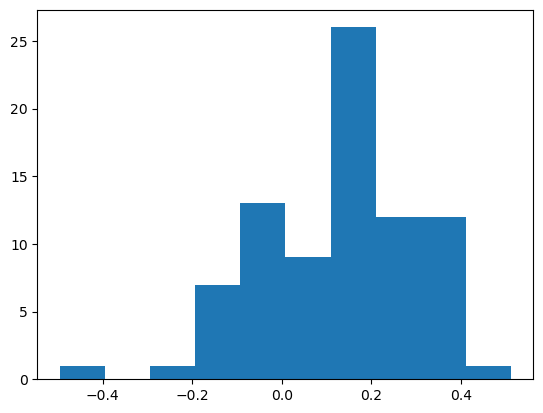

In [37]:
plt.hist(stats_df['sharpe_daily'])

In [40]:
stats_df.describe()

,start_date,end_date,sharpe_daily,cum_return,max_drawdown,average_daily_ret,nav_min,nav_25,nav_median,nav_75,nav_max,num_openings,num_closings,average_holding_period
count,82,82,82.000000,82.000000,82.000000,82.000000,82.000000,82.000000,82.000000,82.000000,82.000000,82.000000,82.000000,82.000000
mean,1997-03-26 12:52:40.975609728,1997-05-24 22:14:38.048780544,0.130232,1.560833,-0.341575,0.003188,0.720203,0.951922,1.131215,1.386622,1.824069,4.439024,3.585366,12.859680
min,1990-08-29 00:00:00,1990-10-26 00:00:00,-0.494874,0.015851,-7.811190,-0.096145,-6.811190,-4.752044,-1.664767,-0.678505,1.000000,1.000000,0.000000,2.300000
25%,1993-12-09 06:00:00,1994-02-07 12:00:00,-0.013289,0.970091,-0.232640,-0.000740,0.848785,0.964819,0.985320,1.020934,1.100318,2.000000,2.000000,4.891667
50%,1997-03-25 00:00:00,1997-05-22 00:00:00,0.148154,1.137114,-0.123111,0.003139,0.980360,1.047380,1.100924,1.159473,1.268573,4.000000,3.000000,7.450000
75%,2000-07-08 18:00:00,2000-09-05 12:00:00,0.259989,1.356908,-0.064936,0.007472,1.000000,1.128661,1.212666,1.354366,1.489315,6.000000,5.000000,17.000000
max,2003-10-29 00:00:00,2003-12-29 00:00:00,0.511442,28.364155,-0.020386,0.085009,1.000000,2.120886,3.922442,12.839946,32.734428,11.000000,11.000000,41.000000
std,NaN,NaN,0.173440,3.048781,0.951558,0.017494,1.047150,0.738161,0.582807,1.382779,3.514615,2.444937,2.504077,12.320458


In [42]:
np.argmin(stats_df['max_drawdown'])

34

In [43]:
test_list[34]

,portfolio_value,residuals,threshold,trade_signal,unwind_signal,position,cum_ret
date,,,,,,,
1996-03-05,0.754778,-0.395786,1.313077,0,0,0.0,1.000000
1996-03-06,-1.183607,-2.334170,1.313077,1,0,1.0,1.000000
1996-03-07,1.970430,0.819867,1.313077,0,1,0.0,-1.664767
1996-03-08,2.123369,0.972806,1.313077,0,0,0.0,-1.664767
1996-03-11,2.361220,1.210657,1.313077,0,0,0.0,-1.664767
1996-03-12,-1.678880,-2.829443,1.313077,1,1,1.0,-1.664767
1996-03-13,-3.868345,-5.018908,1.313077,1,0,1.0,-3.835827
1996-03-14,-2.894130,-4.044693,1.313077,1,0,1.0,-2.869802
1996-03-15,-0.278895,-1.429459,1.313077,1,0,1.0,-0.276551


## Part II: trading snapshot

In [6]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt

with open('output_MRP/test_tables_train8_test2.pkl', 'rb') as file:
    test_table_list = pickle.load(file)



date = []
ret = []
for idx in range(len(test_table_list)):
    date.append(test_table_list[idx].index[-1])
    ret.append(test_table_list[idx]['cum_ret'].iloc[-1])

In [8]:
len(test_table_list)

82

In [9]:
test_table_list[0]

,portfolio_value,residuals,threshold,trade_signal,unwind_signal,position,cum_ret
date,,,,,,,
1990-08-29,33.260481,-0.953379,0.411231,1,0,1.0,1.000000
1990-08-30,32.473904,-1.739956,0.411231,1,0,1.0,0.976351
1990-08-31,33.529234,-0.684625,0.411231,1,0,1.0,1.008080
1990-09-04,32.826902,-1.386958,0.411231,1,0,1.0,0.986964
1990-09-05,32.559069,-1.654790,0.411231,1,0,1.0,0.978912
1990-09-06,32.649936,-1.563923,0.411231,1,0,1.0,0.981644
1990-09-07,33.179032,-1.034827,0.411231,1,0,1.0,0.997551
1990-09-10,31.794401,-2.419458,0.411231,1,0,1.0,0.955921
1990-09-11,32.266355,-1.947505,0.411231,1,0,1.0,0.970111


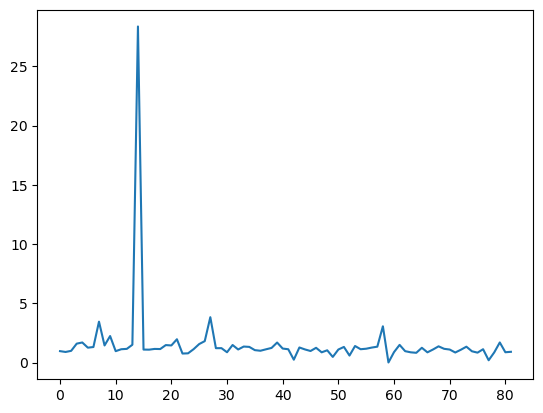

In [7]:
plt.plot(ret)

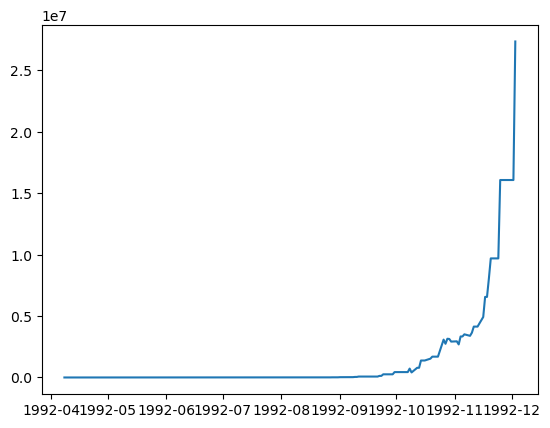

In [48]:
train_table_list[14]
plt.plot(train_table_list[14]['cum_ret'])

In [54]:
train_table_list[14].head(20)

,portfolio_value,residuals,threshold,trade_signal,unwind_signal,position,cum_ret
date,,,,,,,
1992-04-08,12.112588,2.875214,1.59543,-1,0,-1.0,1.000000
1992-04-09,8.902758,-0.334617,1.59543,0,1,0.0,1.265000
1992-04-10,11.490454,2.253079,1.59543,-1,1,-1.0,1.265000
1992-04-13,10.393802,1.156427,1.59543,0,0,-1.0,1.385731
1992-04-14,6.058787,-3.178588,1.59543,1,1,0.0,1.963688
1992-04-15,9.129427,-0.107948,1.59543,0,0,0.0,1.963688
1992-04-16,12.109264,2.871889,1.59543,-1,1,-1.0,1.963688
1992-04-20,8.886468,-0.350907,1.59543,0,1,0.0,2.486310
1992-04-21,8.593868,-0.643507,1.59543,0,0,0.0,2.486310


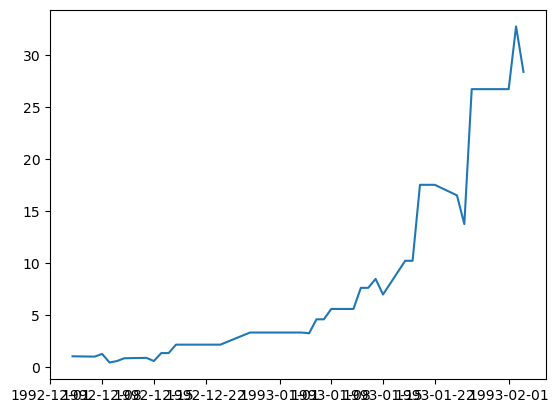

In [55]:
import numpy as np

# np.argmax(ret)
test_table_list[14]

plt.plot(test_table_list[14]['cum_ret'])

In [26]:
# 1. Concatenate the dataframes vertically
concatenated_df = pd.concat(test_tables_list, axis=0, ignore_index=True)

# 2. Calculate the adjusted cumulative return
def calculate_continuous_cumulative_return(df):
    # Create a new column for the continuous cumulative return
    df = df.copy()  # To avoid modifying the original dataframe
    df['continuous_cum_ret'] = df['cum_ret'].copy()
    
    # Keep track of where each original dataframe starts and ends
    start_indices = [0]
    for i in range(1, len(test_tables_list)):
        start_indices.append(start_indices[i-1] + len(test_tables_list[i-1]))
    
    # For each dataframe except the first, adjust the cumulative return
    for i in range(1, len(test_tables_list)):
        start_idx = start_indices[i]
        end_idx = start_indices[i] + len(test_tables_list[i]) if i < len(test_tables_list) - 1 else len(df)
        
        # Get the last cumulative return from the previous dataframe
        previous_last_return = df.loc[start_indices[i] - 1, 'continuous_cum_ret']
        
        # Adjust the cumulative returns in this dataframe
        df.loc[start_idx:end_idx-1, 'continuous_cum_ret'] = df.loc[start_idx:end_idx-1, 'cum_ret'] * previous_last_return
    
    return df

df = calculate_continuous_cumulative_return(concatenated_df)